# **Determining Biofilm Surface Area from 2D Images**

## **Image Loading and Preprocessing**


### **Importing Images from Utils**

In [1]:
from utils import *
print("All libraries successfully imported")

All libraries successfully imported


### **Preprocessing Biofilm Images**

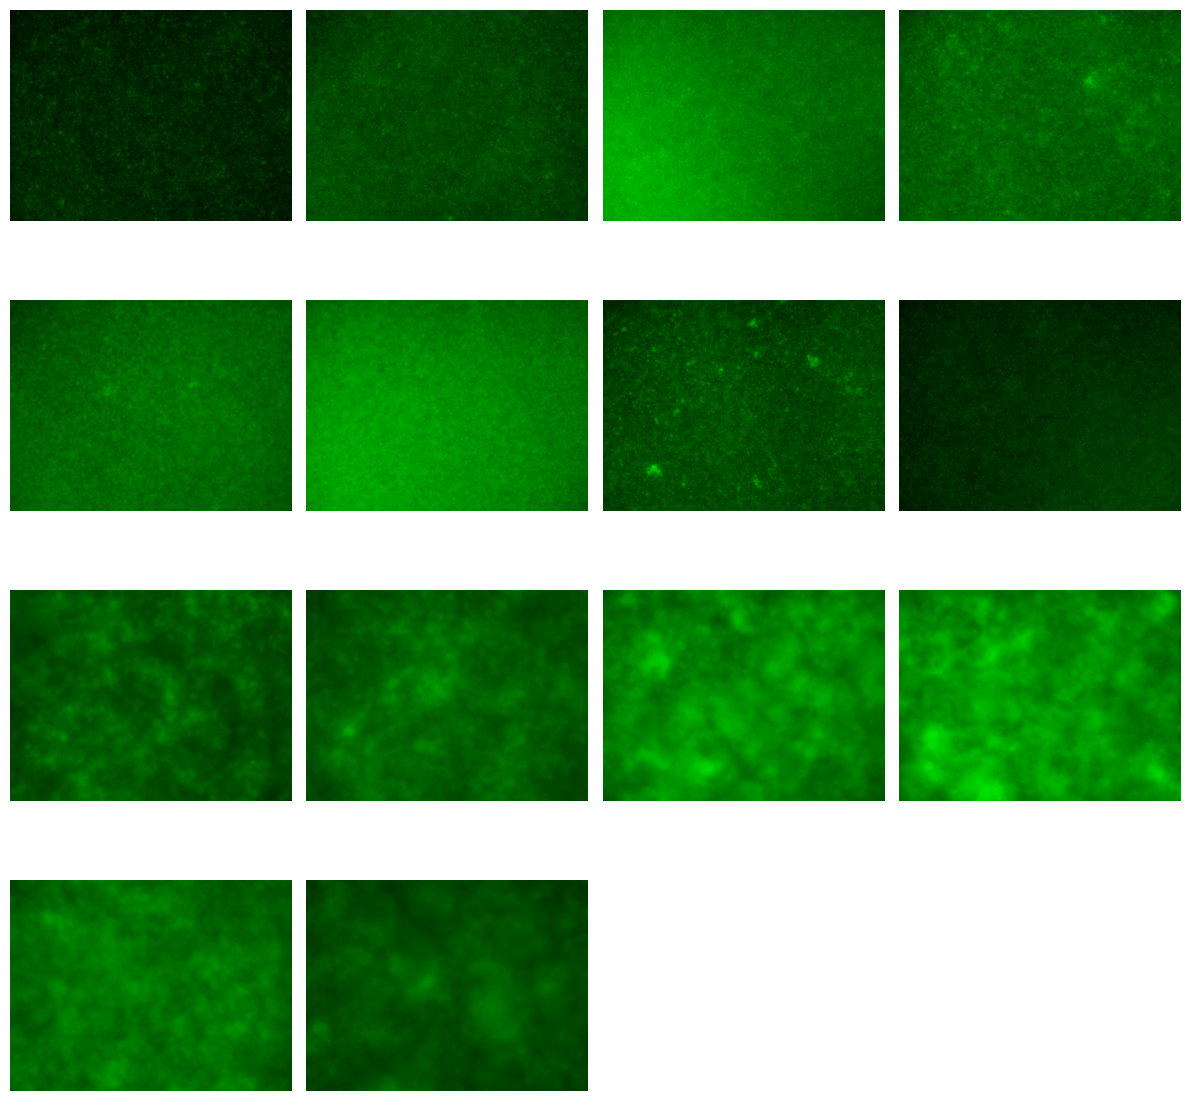

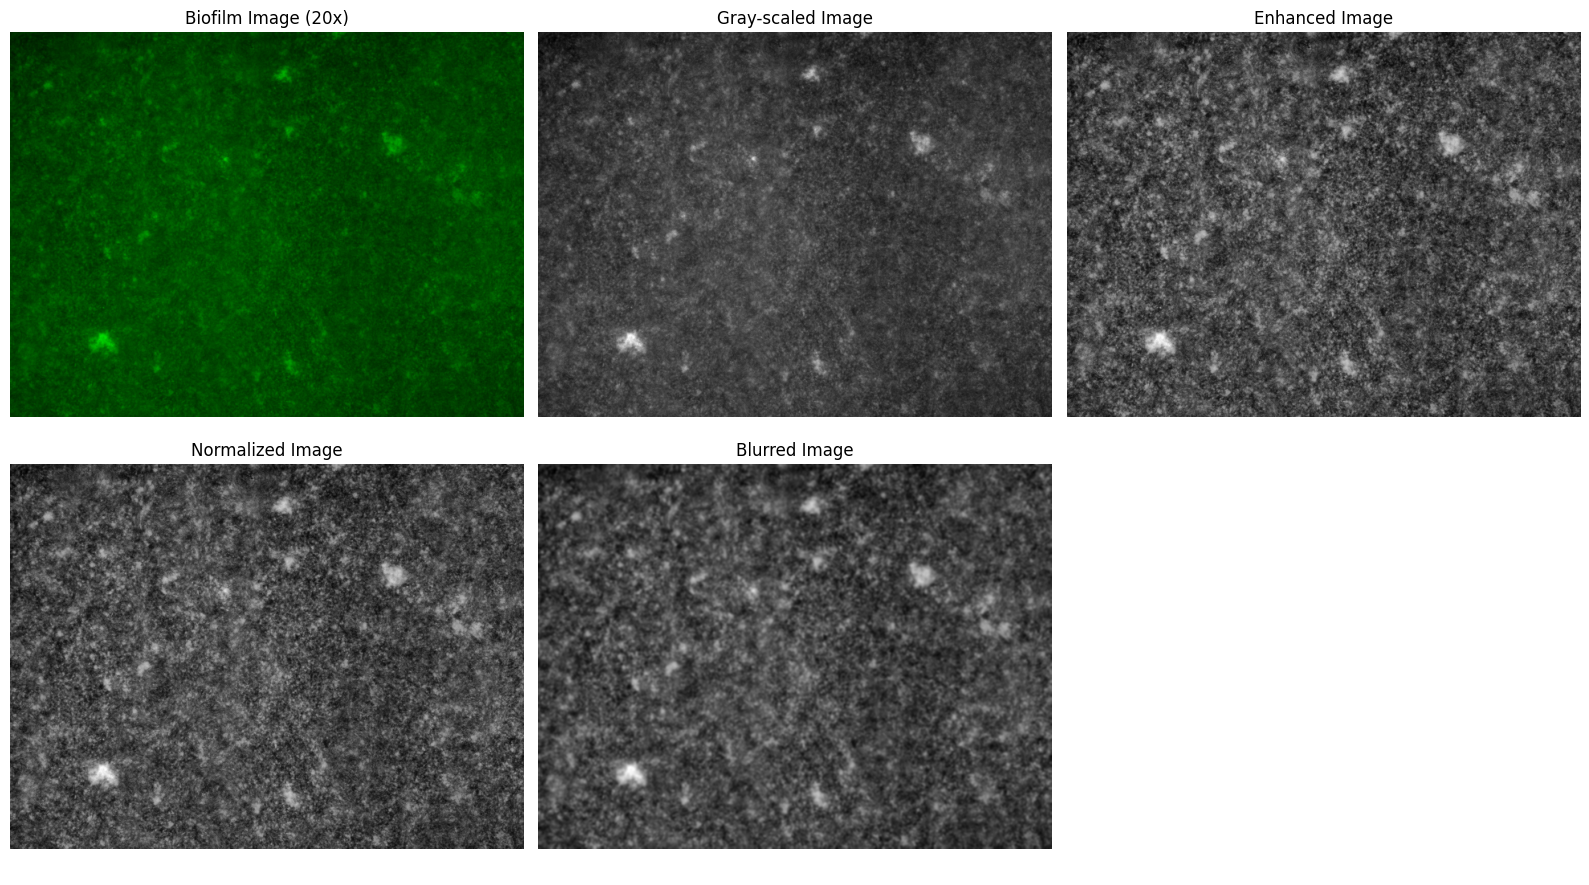

In [10]:
biofilm_images = load_images("biofilm_data/biofilm")
display_grid_of_images(biofilm_images)
image = biofilm_images [6]
gray_image, enhanced_image, normalized_image, blurred_image = preprocess(image)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

axes[0, 0].imshow(image)
axes[0, 0].set_title(f"Biofilm Image (20x)")
axes[0, 0].axis('off')

axes[0, 1].imshow(gray_image, cmap='gray')
axes[0, 1].set_title("Gray-scaled Image")
axes[0, 1].axis('off')

axes[0, 2].imshow(enhanced_image, cmap='gray')
axes[0, 2].set_title("Enhanced Image")
axes[0, 2].axis('off')

axes[1, 0].imshow(normalized_image, cmap='gray')
axes[1, 0].set_title("Normalized Image")
axes[1, 0].axis('off')

axes[1, 1].imshow(blurred_image, cmap='gray')
axes[1, 1].set_title("Blurred Image")
axes[1, 1].axis('off')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## **Segmentation Techniques**

### **Otsu Segmentation**
*Automatically determines a thresholding value that is used to determine what is/isn't biofilm*

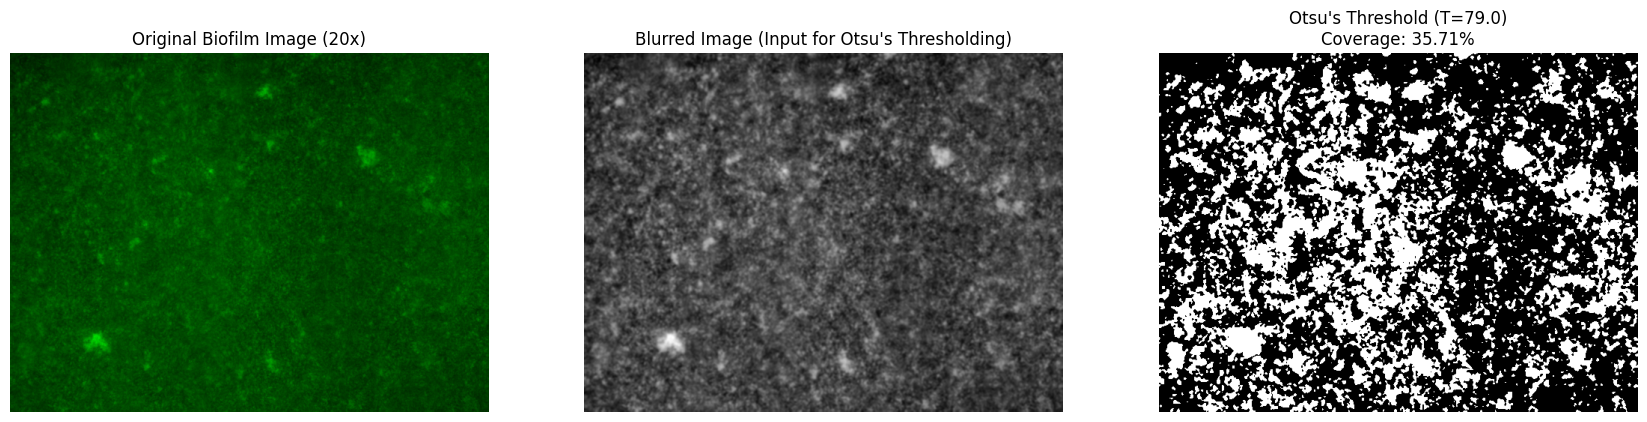

--- Segmentation Results (Otsu's) ---
Optimal Global Threshold: 79.0
Biofilm Surface Area Coverage: 35.71%


In [3]:
percent_coverage, otsu_mask, optimal_threshold = otsu_thresholding(blurred_image)

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

axes[0].imshow(image)
axes[0].set_title("Original Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(blurred_image, cmap='gray')
axes[1].set_title("Blurred Image (Input for Otsu's Thresholding)")
axes[1].axis('off')

axes[2].imshow(otsu_mask, cmap='gray')
axes[2].set_title(f"Otsu's Threshold (T={optimal_threshold})\nCoverage: {percent_coverage:.2f}%")
axes[2].axis('off')

plt.show()

print(f"--- Segmentation Results (Otsu's) ---")
print(f"Optimal Global Threshold: {optimal_threshold}")
print(f"Biofilm Surface Area Coverage: {percent_coverage:.2f}%")

### **Iterative Thresholding**
*Assumes that the image is composed of two main groups:*

 1. Foreground (biomass)
 2. Background (not biomass)

*The algorithm makes an initial guess, averages the gray-scaled pixel values above and below the threshold, creates a new threshold from the average of those two averages, and continues to iterate until the threshold value stops changing*

*Calculates the optimal threshold for a grayscale image using the* 
*Iterative Selection method described by Yang et al. (2001).*

*Based on: Yang et al. (2001) Wat. Res. Vol. 35, No. 5, pp. 1149-1158.*

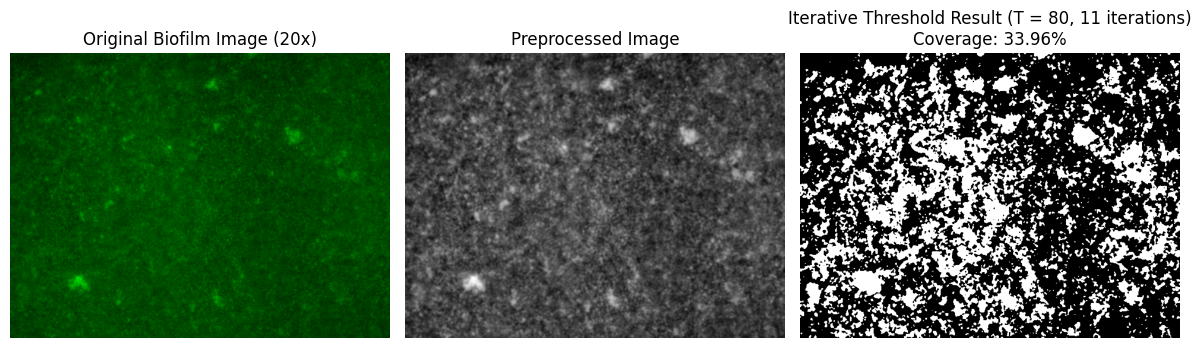

--- Segmentation Results (Iterative) ---
Optimal Global Threshold: 80
Converged in 11 iterations.
Biofilm Surface Area Coverage: 33.96%


In [4]:
optimal_t, iterations = iterative_threshold(blurred_image)

ret, iterative_mask = cv2.threshold(blurred_image, optimal_t, 255, cv2.THRESH_BINARY)
biofilm_pixels = np.count_nonzero(iterative_mask)
total_pixels = iterative_mask.size
percent_coverage = (biofilm_pixels / total_pixels) * 100

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Biofilm Image (20x)")
axes[0].axis('off')

axes[1].imshow(blurred_image, cmap='gray')
axes[1].set_title("Preprocessed Image")
axes[1].axis('off')

axes[2].imshow(iterative_mask, cmap='gray')
axes[2].set_title(f"Iterative Threshold Result (T = {optimal_t}, {iterations} iterations)\nCoverage: {percent_coverage:.2f}%")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"--- Segmentation Results (Iterative) ---")
print(f"Optimal Global Threshold: {optimal_t}")
print(f"Converged in {iterations} iterations.")
print(f"Biofilm Surface Area Coverage: {percent_coverage:.2f}%")

## **Surface Area Calculation**
*Assuming each pixel is 1.13 microns by 1.13 microns (need to double check this is correct)*

In [5]:
biofilm_pixels, area_per_pixel_um2, total_area_um2, total_area_mm2 = biofilm_area(image)

# Calculate area using Otsu's thresholding result (binary_mask from Cell 12)
otsu_area_results = biofilm_area(otsu_mask, pixel_side_length_um=1.13)

# Calculate area using iterative thresholding result (binary_image from Cell 15)
iterative_area_results = biofilm_area(iterative_mask, pixel_side_length_um=1.13)

# Display results
print("=" * 60)
print("--- Physical Area Results ---")
print("=" * 60)
print("Otsu Thresholding Surface Area Results:")
print(f"  Biofilm Pixel Count: {otsu_area_results['biofilm_pixel_count']:,}")
print(f"  Area per Pixel: {otsu_area_results['area_per_pixel_um2']:.2f} μm²")
print(f"  Total Area: {otsu_area_results['total_area_um2']:.2f} μm²")
print(f"  Total Area: {otsu_area_results['total_area_mm2']:.4f} mm²")

print("\nIterative Thresholding Surface Area Results:")
print(f"  Biofilm Pixel Count: {iterative_area_results['biofilm_pixel_count']:,}")
print(f"  Area per Pixel: {iterative_area_results['area_per_pixel_um2']:.2f} μm²")
print(f"  Total Area: {iterative_area_results['total_area_um2']:.2f} μm²")
print(f"  Total Area: {iterative_area_results['total_area_mm2']:.4f} mm²")
print("=" * 60)

--- Physical Area Results ---
Otsu Thresholding Surface Area Results:
  Biofilm Pixel Count: 109,699
  Area per Pixel: 1.28 μm²
  Total Area: 140074.65 μm²
  Total Area: 0.1401 mm²

Iterative Thresholding Surface Area Results:
  Biofilm Pixel Count: 104,328
  Area per Pixel: 1.28 μm²
  Total Area: 133216.42 μm²
  Total Area: 0.1332 mm²


# **Final Table of Results**

In [6]:
# Initialize list for results
analysis_results = []

print(f"Starting analysis on {len(biofilm_images)} images...")

for i, img in enumerate(biofilm_images):
    if img is not None and img.size > 0:
        try:
            result = analyze_image(image=img, image_id=f"image_{i}")
            analysis_results.append(result)
            
        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")

df_results = pd.DataFrame(analysis_results)

print("\nAnalysis Complete!")
display(df_results)

Starting analysis on 14 images...

Analysis Complete!


,image_id,otsu_threshold,otsu_percent_coverage,otsu_pixel_count,otsu_area_mm2,iter_threshold,iter_iterations,iter_percent_coverage,iter_pixel_count,iter_area_mm2
0,image_0,99.0,38.848307,119342,0.152388,100,9,37.555339,115370,0.147316
1,image_1,109.0,46.145508,141759,0.181012,110,8,44.661133,137199,0.175189
2,image_2,113.0,42.812174,131519,0.167937,114,7,41.884440,128669,0.164297
3,image_3,95.0,40.198242,123489,0.157683,96,9,38.532552,118372,0.151149
4,image_4,116.0,47.559245,146102,0.186558,117,7,45.889974,140974,0.180010
5,image_5,132.0,53.293620,163718,0.209052,132,5,53.293620,163718,0.209052
6,image_6,79.0,35.709310,109699,0.140075,80,11,33.960938,104328,0.133216
7,image_7,113.0,45.890625,140976,0.180012,114,8,44.430664,136491,0.174285
8,image_8,104.0,38.523112,118343,0.151112,105,8,37.662760,115700,0.147737
9,image_9,90.0,36.430664,111915,0.142904,91,10,35.357747,108619,0.138696
